In [1]:
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from PIL import Image
import os
import glob
import zipfile
from skimage import transform as tform
from sklearn import decomposition, mixture

In [2]:
root_images="../input/all-dogs/all-dogs/"
root_annots="../input/annotation/Annotation/"

all_images=os.listdir("../input/all-dogs/all-dogs/")
print(f"Total images : {len(all_images)}")

breeds = glob.glob('../input/annotation/Annotation/*')
annotation=[]
for b in breeds:
    annotation+=glob.glob(b+"/*")
print(f"Total annotation : {len(annotation)}")

breed_map={}
for annot in annotation:
    breed=annot.split("/")[-2]
    index=breed.split("-")[0]
    breed_map.setdefault(index,breed)
    
print(f"Total Breeds : {len(breed_map)}")

Total images : 20579
Total annotation : 20580
Total Breeds : 120


# Show several cropped dog images 
bounding box code taken from "" kernel 

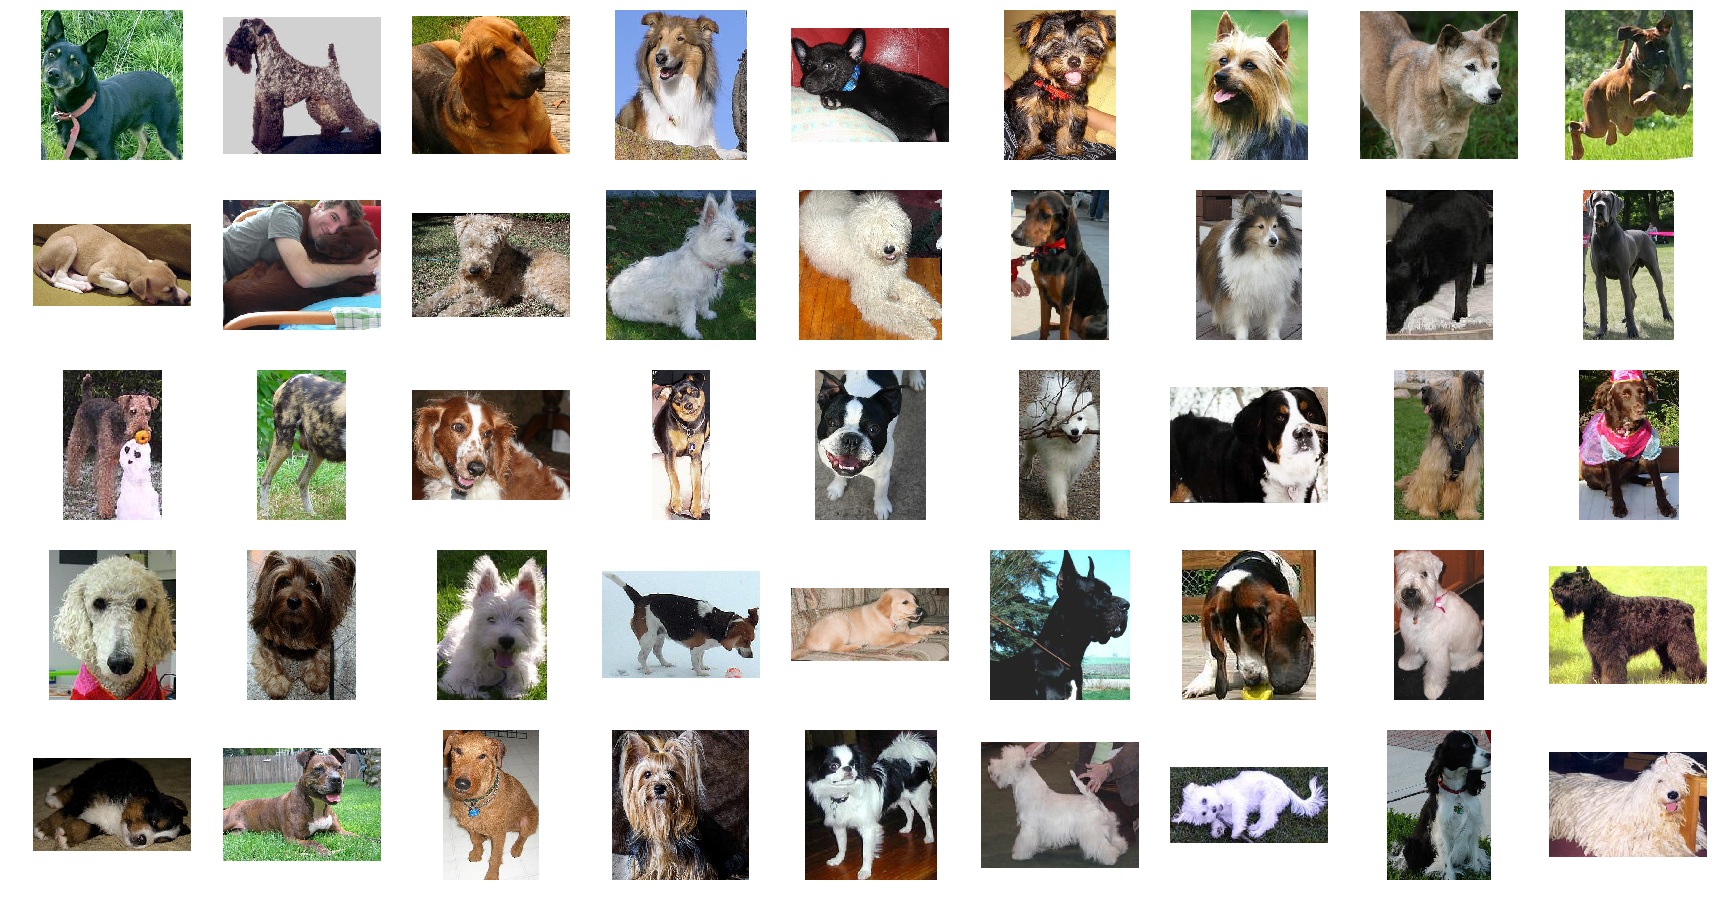

In [3]:
def bounding_box(image):
    bpath=root_annots+str(breed_map[image.split("_")[0]])+"/"+str(image.split(".")[0])
    tree = ET.parse(bpath)
    root = tree.getroot()
    objects = root.findall('object')
    for o in objects:
        bndbox = o.find('bndbox') # reading bound box
        xmin = int(bndbox.find('xmin').text)
        ymin = int(bndbox.find('ymin').text)
        xmax = int(bndbox.find('xmax').text)
        ymax = int(bndbox.find('ymax').text)
        
    return (xmin,ymin,xmax,ymax)

num_rows = 5
num_cols = 9
num_images_to_show = num_rows*num_cols
selected_images = np.random.choice(all_images,size=num_images_to_show,replace=False)

plt.figure(figsize=(30,16))
for k, image_filename in enumerate(selected_images):
    bbox = bounding_box(image_filename)
    orig_image = Image.open(os.path.join(root_images, image_filename))
    cropped_image = orig_image.crop(bbox)
    
    plt.subplot(num_rows,num_cols,k+1); plt.imshow(cropped_image); plt.axis("off")

# Create a small dataset of resized images

In [4]:
# create a small dataset of resized images
num_images_in_dataset = 20000
image_dimention = 64
resize_shape = (image_dimention, image_dimention)

selected_images = np.random.choice(all_images, size=num_images_in_dataset, replace=False)

# create a matrix to hold all images
image_dataset_4D_matrix = np.zeros((image_dimention,image_dimention,3,num_images_in_dataset), dtype=np.uint8)

# fill up the matrix with images
for k, image_filename in enumerate(selected_images):
    bbox = bounding_box(image_filename)
    orig_image = Image.open(os.path.join(root_images, image_filename))
    cropped_image = orig_image.crop(bbox)
    resized_image = tform.resize(np.array(cropped_image), resize_shape, preserve_range=True).astype(np.uint8)

    image_dataset_4D_matrix[:,:,:,k] = resized_image
    
print('finished collecting dataset')

finished collecting dataset


# Create PCA model of the data
210 - explain ~90% of the variance

In [5]:
# create PCA model of the data
print(image_dataset_4D_matrix.shape)
num_components = 768
X = image_dataset_4D_matrix.reshape(image_dimention*image_dimention*3,-1).T

dog_PCA = decomposition.PCA(n_components=num_components, whiten=True)
dog_PCA.fit(X)

print('finished training PCA model')

(64, 64, 3, 20000)
finished training PCA model


# Show histograms of PCA projections

(20000, 12288) (20000, 768)
108.87677130533854 63.9207307181584
108.87677130533847 62.84672111052629


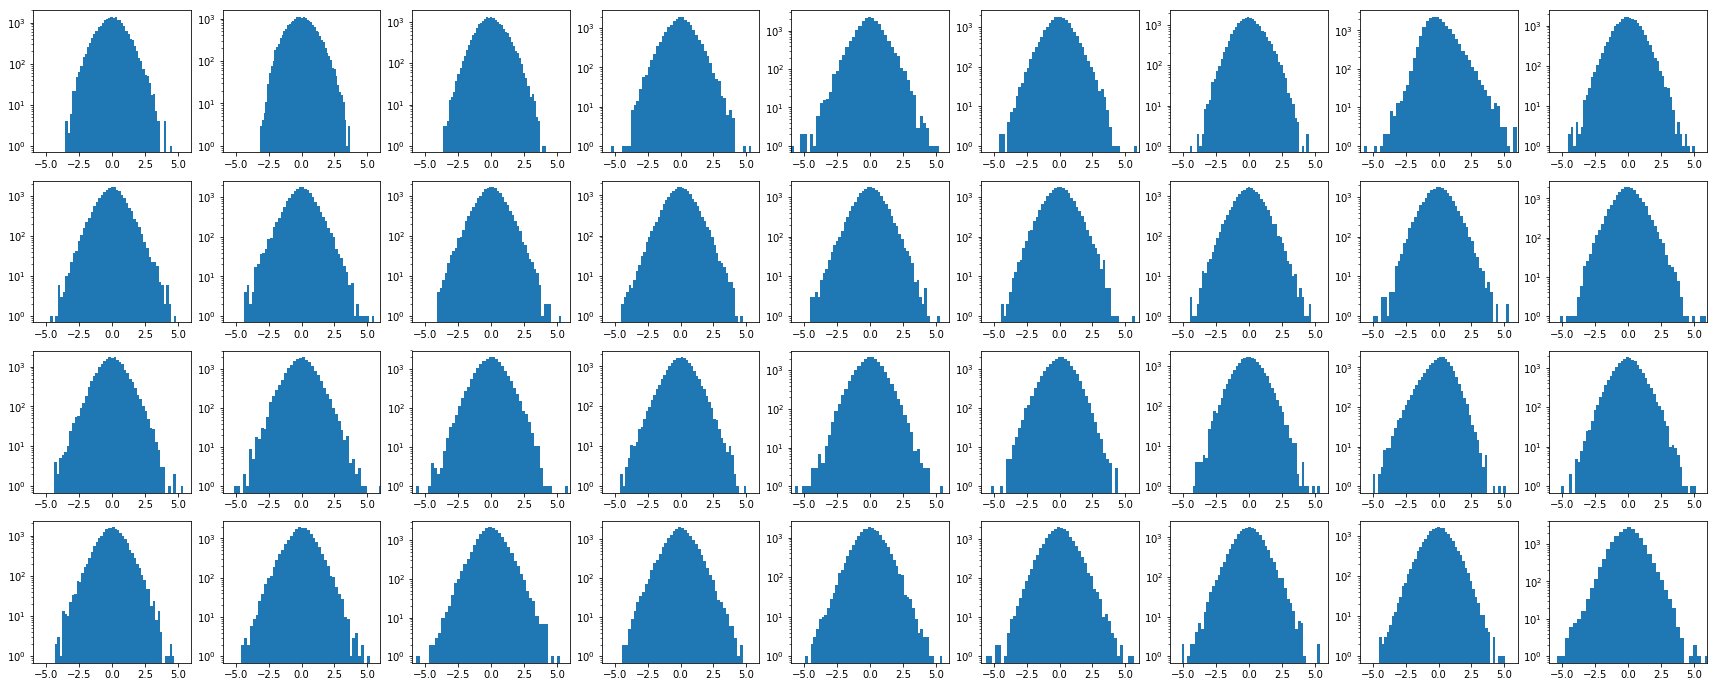

In [6]:
X_pca = dog_PCA.transform(X)
X_rec = dog_PCA.inverse_transform(X_pca)
plt.figure(figsize=(30,12))
for k in range(36):
    plt.subplot(4,9,k+1); plt.hist(X_pca[:,k], bins=50, log=True); plt.xlim(-6,6)

print(X.shape, X_pca.shape)
print(X.mean(), X.std())
print(X_rec.mean(), X_rec.std())

# Show cumulative explained variance plot of PCA

total explained percent by 768 components - 96.6%


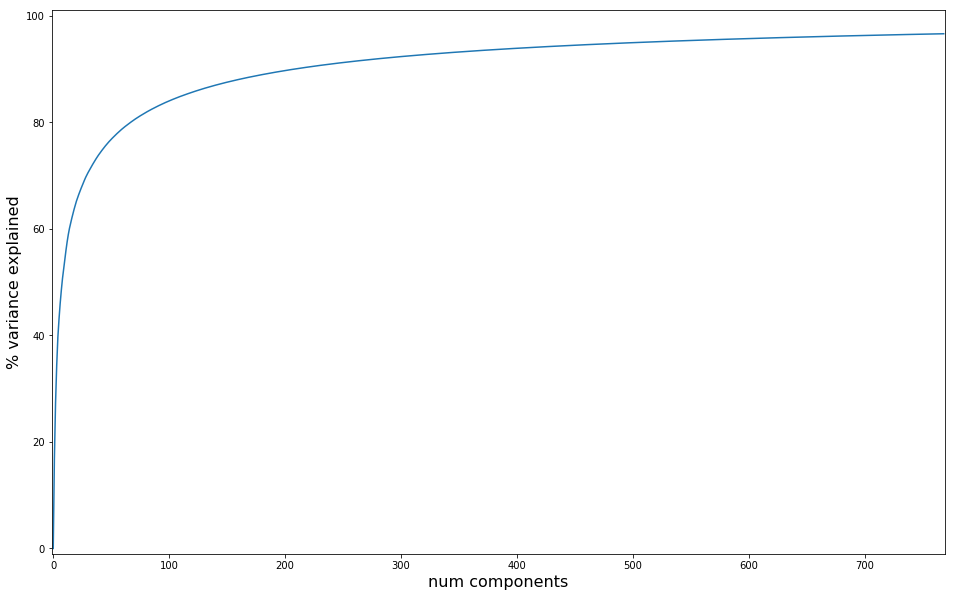

In [7]:
# show cumulative variance explained
plt.figure(figsize=(16,10))
plt.plot(100*np.concatenate((np.array([0]),np.cumsum(dog_PCA.explained_variance_ratio_))))
plt.xlabel('num components', fontsize=16); plt.ylabel('% variance explained', fontsize=16); plt.ylim(-1,101); plt.xlim(-1,num_components+1);
print('total explained percent by %d components - %.1f%s' %(num_components, 100*dog_PCA.explained_variance_ratio_.sum(),'%'))

# Show the main variance directions in the data

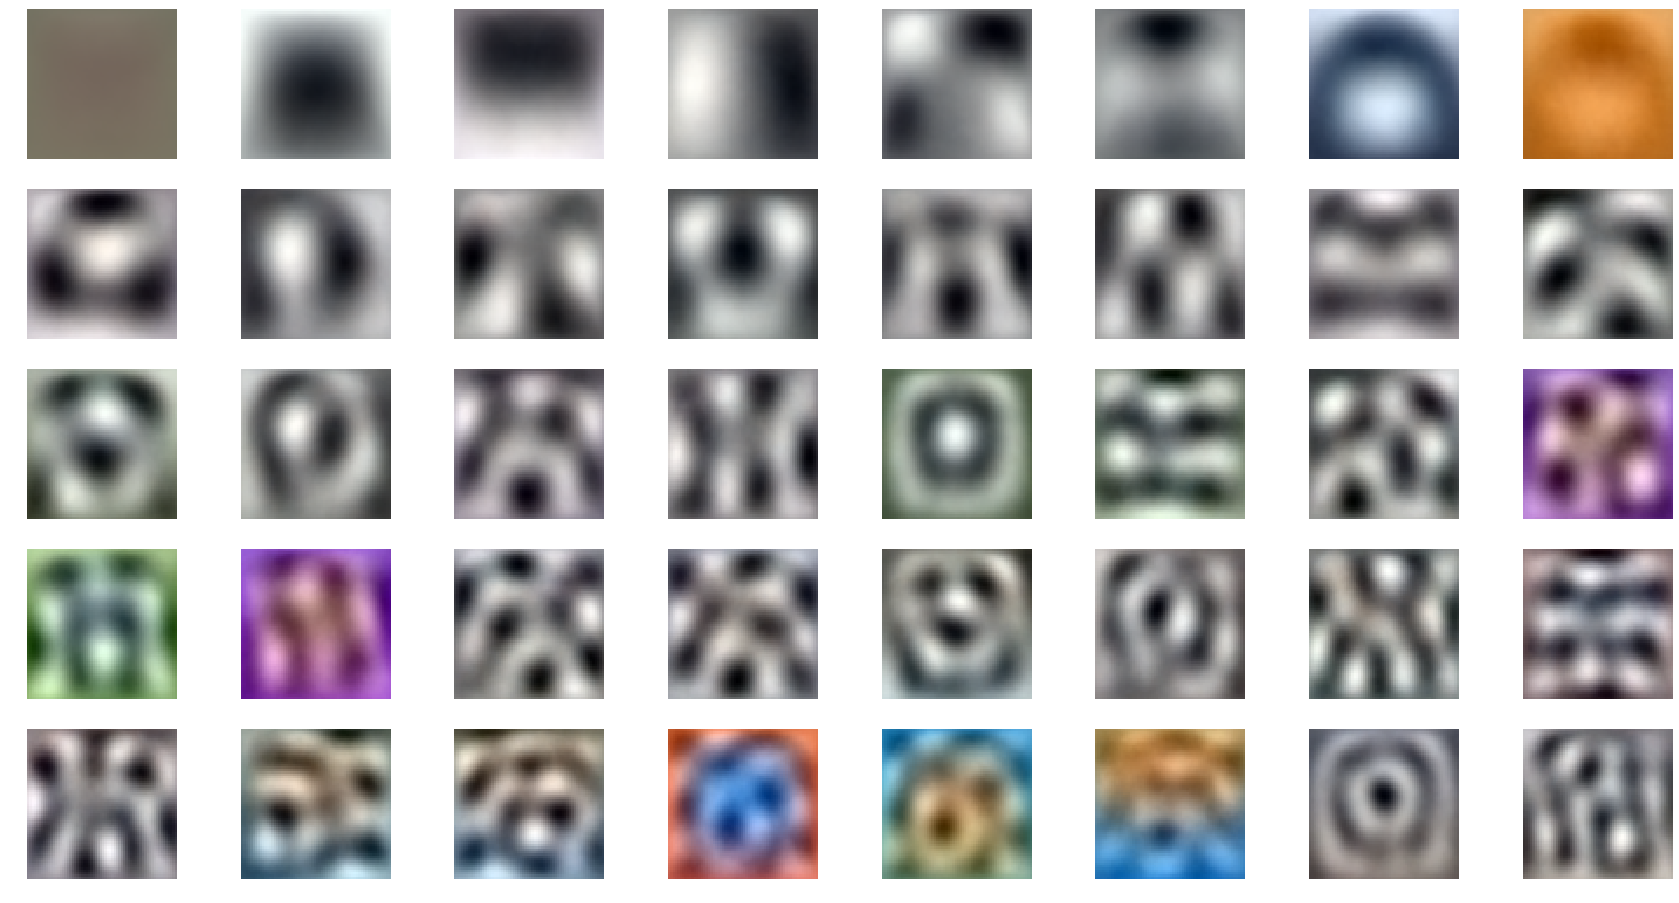

In [8]:
def normize_image_for_plotting(input_image):
    min_val = input_image.min()
    med_val = input_image.mean()
    max_val = input_image.max()

    output_image = input_image - med_val
    output_image /= max((max_val-med_val),(med_val-min_val))
    output_image = (255*(0.5*output_image + 0.5)).astype(np.uint8)
    
    return output_image
    
# show the mean sample and the first couple of eigenvectors (should look a little like furier basis)
num_rows = 5
num_cols = 8
num_images_to_show = num_rows*num_cols

mean_image = np.reshape(dog_PCA.mean_,(image_dimention,image_dimention,3)).astype(np.uint8)

plt.figure(figsize=(30,16))
plt.subplot(num_rows,num_cols,1); plt.imshow(mean_image); plt.axis('off')
for k in range(1, num_rows*num_cols):
    eigenvector = dog_PCA.components_[k,:]
    eigenvector_image = np.reshape(eigenvector,(image_dimention,image_dimention,3))
    
    plt.subplot(num_rows,num_cols,k+1); plt.imshow(normize_image_for_plotting(eigenvector_image)); plt.axis('off')

# Show some model reconstructions

(45, 12288) 111.87753465433467 65.36793631599343


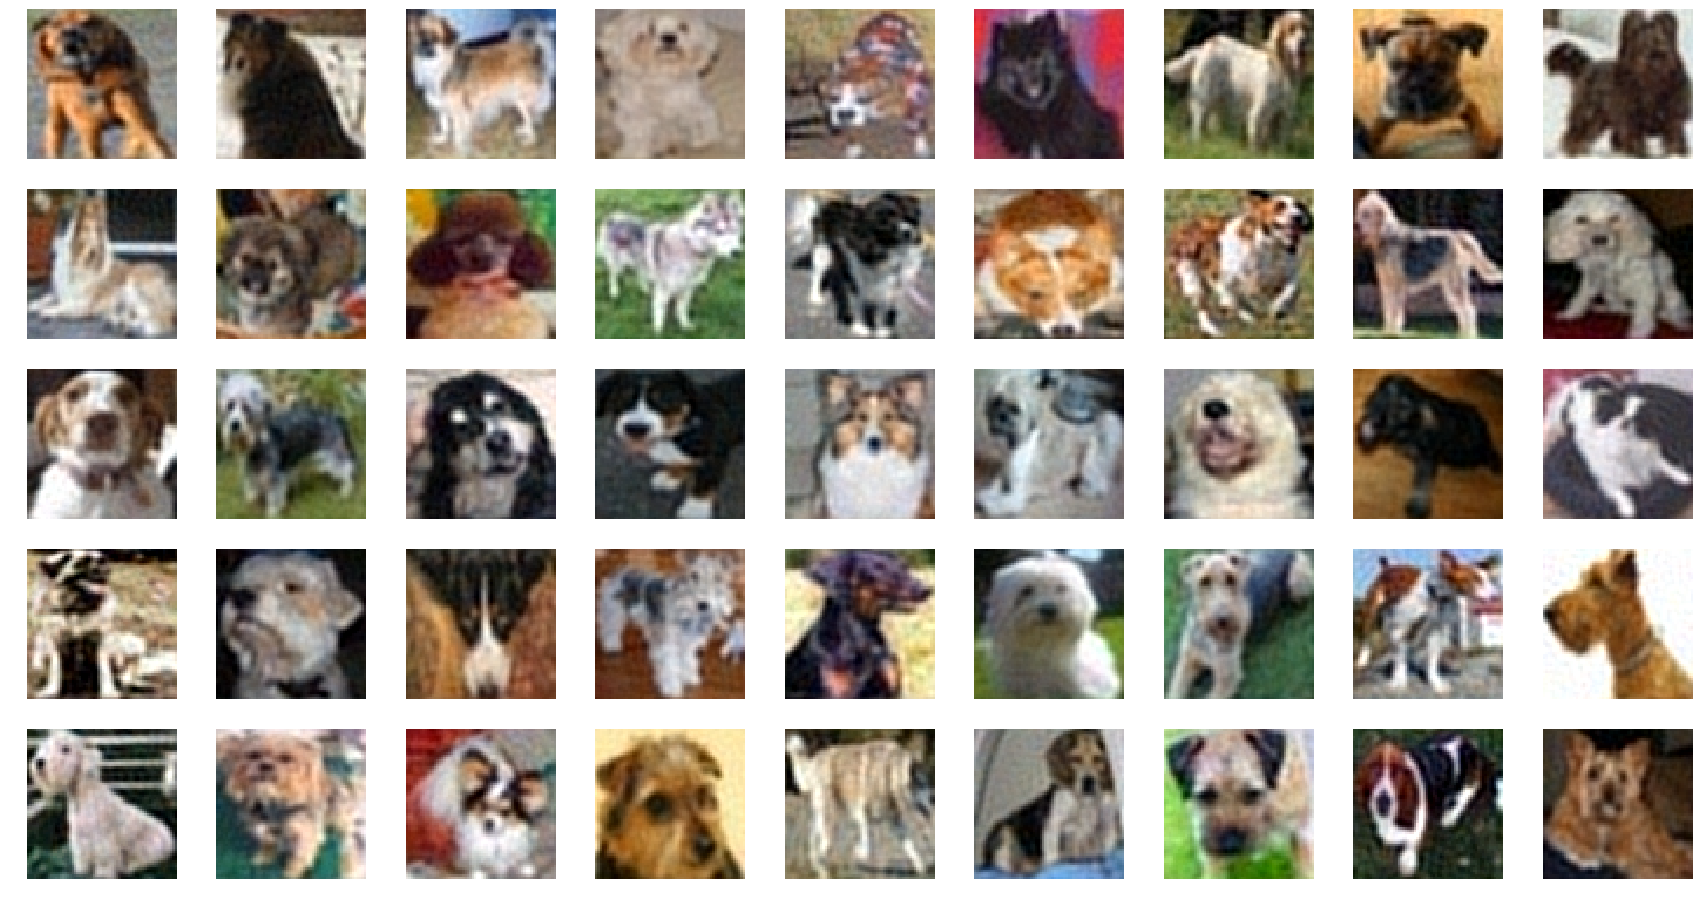

In [9]:
# show several model reconstructions
num_rows = 5
num_cols = 9
num_images_to_show = num_rows*num_cols

selected_inds = np.random.choice(num_images_in_dataset, size=num_images_to_show, replace=False)
random_doglike_vectors = X_rec[selected_inds,:]
print(random_doglike_vectors.shape, random_doglike_vectors.mean(), random_doglike_vectors.std())

plt.figure(figsize=(30,16))
for k in range(num_images_to_show):
    doglike_image = np.reshape(random_doglike_vectors[k,:],(image_dimention,image_dimention,3))
    doglike_image[doglike_image > 255] = 255
    doglike_image[doglike_image <   0] =   0
    
    plt.subplot(num_rows,num_cols,k+1); plt.imshow(doglike_image.astype(np.uint8)); plt.axis("off")

# Generate some random samples from a multivariate gaussian distribution

(45, 768) 0.003456405632435842 1.000286706174348
(45, 12288) 107.96164354535242 62.34469610422896


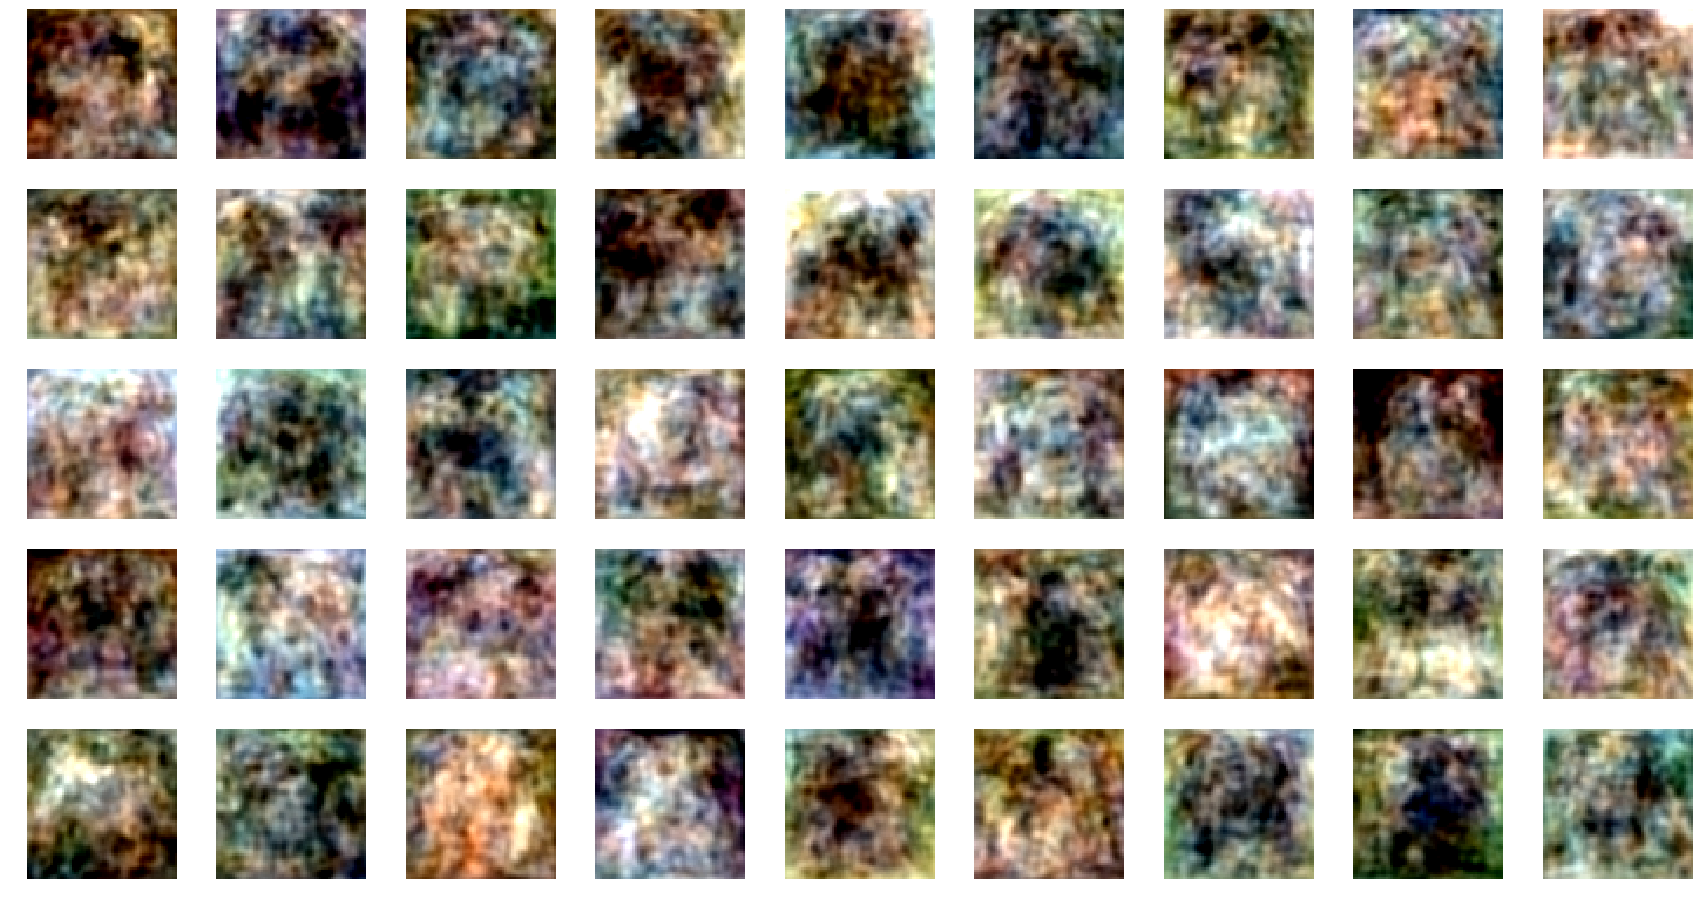

In [10]:
# generate several random samples from the gaussian model and present them
dog_single_gaussian_model = mixture.GaussianMixture(n_components=1, covariance_type='diag')
dog_single_gaussian_model.fit(X_pca)

num_rows = 5
num_cols = 9
num_images_to_show = num_rows*num_cols

random_latents = dog_single_gaussian_model.sample(num_images_to_show)[0]
print(random_latents.shape, random_latents.mean(), random_latents.std())

random_doglike_vectors = dog_PCA.inverse_transform(random_latents)
print(random_doglike_vectors.shape, random_doglike_vectors.mean(), random_doglike_vectors.std())

plt.figure(figsize=(30,16))
for k in range(num_images_to_show):
    doglike_image = np.reshape(random_doglike_vectors[k,:],(image_dimention,image_dimention,3))
    doglike_image[doglike_image > 255] = 255
    doglike_image[doglike_image <   0] =   0

    plt.subplot(num_rows,num_cols,k+1); plt.imshow(doglike_image.astype(np.uint8)); plt.axis("off")

# Train several GMM models and compare them
plot train and validation LogLikelihoods as function of number of gaussians

for 1 gaussians: (train,valid) LogLikelihood = (-1089.73507,-1090.85034)
for 2 gaussians: (train,valid) LogLikelihood = (-1067.81070,-1069.91090)
for 3 gaussians: (train,valid) LogLikelihood = (-1089.44712,-1090.85046)
for 4 gaussians: (train,valid) LogLikelihood = (-1061.64915,-1064.23307)
for 5 gaussians: (train,valid) LogLikelihood = (-1067.34659,-1069.91051)
for 6 gaussians: (train,valid) LogLikelihood = (-1067.22842,-1069.91140)
for 7 gaussians: (train,valid) LogLikelihood = (-1061.34150,-1064.23385)
for 8 gaussians: (train,valid) LogLikelihood = (-1057.43237,-1060.73229)
for 9 gaussians: (train,valid) LogLikelihood = (-1060.90446,-1064.23360)
for 10 gaussians: (train,valid) LogLikelihood = (-1057.10173,-1060.73339)
for 11 gaussians: (train,valid) LogLikelihood = (-1057.14602,-1060.73126)
for 12 gaussians: (train,valid) LogLikelihood = (-1088.01645,-1090.85055)
for 13 gaussians: (train,valid) LogLikelihood = (-1055.35197,-1059.25598)
for 14 gaussians: (train,valid) LogLikelihood =

/opt/conda/lib/python3.6/site-packages/sklearn/mixture/base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  % (init + 1), ConvergenceWarning)


for 150 gaussians: (train,valid) LogLikelihood = (-1034.06411,-1058.43935)


Text(0.5, 0, 'num gaussians')

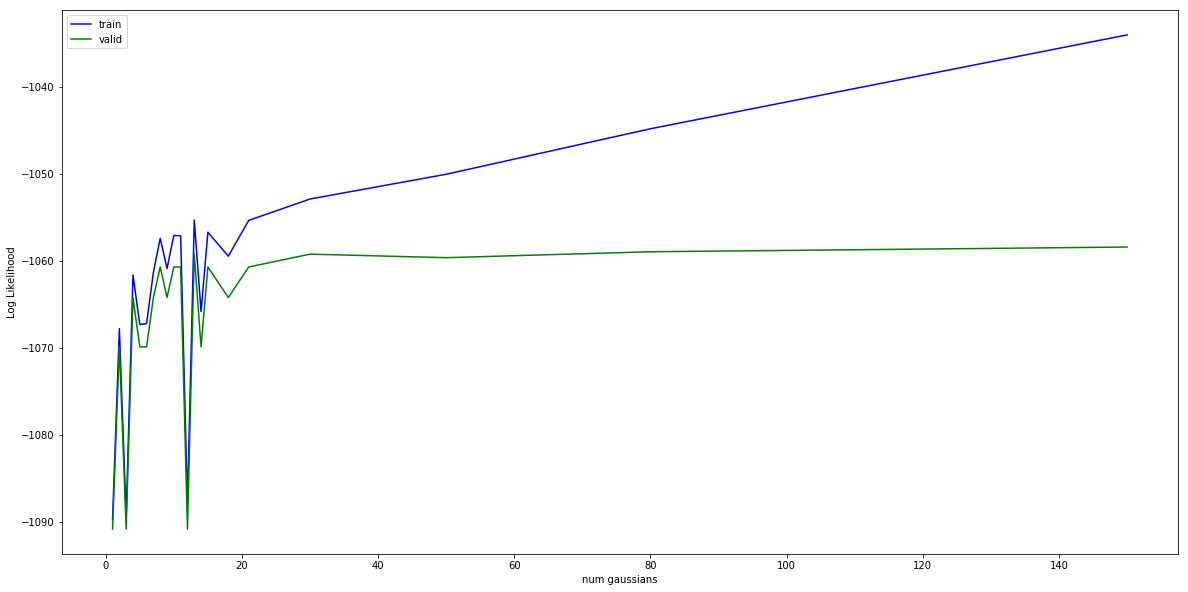

In [11]:
num_gaussians_to_try = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,18,21,30,50,80,150]
covariance_matrix_type = 'diag'
covariance_matrix_regularization = 5e-3

valid_fraction = 0.15
valid_cutoff = int((1-valid_fraction)*X_pca.shape[0])
rand_perm = np.random.permutation(X_pca.shape[0])
X_pca_train = X_pca[rand_perm[:valid_cutoff],:]
X_pca_valid = X_pca[rand_perm[valid_cutoff:],:]

train_LogLikelihood = []
valid_LogLikelihood = []
for num_gaussians in num_gaussians_to_try:
    
    curr_dog_GMM = mixture.GaussianMixture(n_components=num_gaussians, covariance_type=covariance_matrix_type, 
                                           reg_covar=covariance_matrix_regularization, verbose=0, verbose_interval=1)
    curr_dog_GMM.fit(X_pca_train)
    train_LL = curr_dog_GMM.score_samples(X_pca_train).mean()
    valid_LL = curr_dog_GMM.score_samples(X_pca_valid).mean()
    
    print('for %d gaussians: (train,valid) LogLikelihood = (%.5f,%.5f)' %(num_gaussians, train_LL, valid_LL))
    
    train_LogLikelihood.append(train_LL)
    valid_LogLikelihood.append(valid_LL)

plt.figure(figsize=(20,10))
plt.plot(num_gaussians_to_try, train_LogLikelihood, color='b')
plt.plot(num_gaussians_to_try, valid_LogLikelihood, color='g')
plt.legend(['train','valid'])
plt.ylabel('Log Likelihood'); plt.xlabel('num gaussians')

# Select the best number of gaussians and retrain on all data
perform selection according to validation data

In [12]:
# train a mixture of gaussians model in the PCA space
num_gaussians = num_gaussians_to_try[np.argmax(valid_LogLikelihood)]
num_gaussians = 15000
print('selected number of gaussians is %d' %(num_gaussians))

covariance_matrix_type = 'diag'
covariance_matrix_regularization = 1e-3
dog_gaussian_mixture_model = mixture.GaussianMixture(n_components=num_gaussians, covariance_type=covariance_matrix_type, 
                                    reg_covar=covariance_matrix_regularization, verbose=2, verbose_interval=1)

dog_gaussian_mixture_model.fit(X_pca)

print('finished training GMM')

selected number of gaussians is 15000
Initialization 0
  Iteration 1	 time lapse 1724.63674s	 ll change inf
  Iteration 2	 time lapse 112.29228s	 ll change 1.07232
  Iteration 3	 time lapse 112.40246s	 ll change 0.83143
  Iteration 4	 time lapse 112.41302s	 ll change 0.21717
  Iteration 5	 time lapse 112.63916s	 ll change 0.09722
  Iteration 6	 time lapse 112.63591s	 ll change 0.05639
  Iteration 7	 time lapse 113.23001s	 ll change 0.03988
  Iteration 8	 time lapse 113.30426s	 ll change 0.03229
  Iteration 9	 time lapse 114.11600s	 ll change 0.02493
  Iteration 10	 time lapse 108.40998s	 ll change 0.02134
  Iteration 11	 time lapse 109.11479s	 ll change 0.01986
  Iteration 12	 time lapse 108.01375s	 ll change 0.01553
  Iteration 13	 time lapse 107.65933s	 ll change 0.01330
  Iteration 14	 time lapse 108.30395s	 ll change 0.01149
  Iteration 15	 time lapse 108.43137s	 ll change 0.01147
  Iteration 16	 time lapse 108.74154s	 ll change 0.01049
  Iteration 17	 time lapse 108.28131s	 ll cha

# Generate several random samples from the gaussian mixture model

(45, 768) -0.006089333244091116 1.0443330657317624
(45, 12288) 112.3397441981471 65.98115376573229


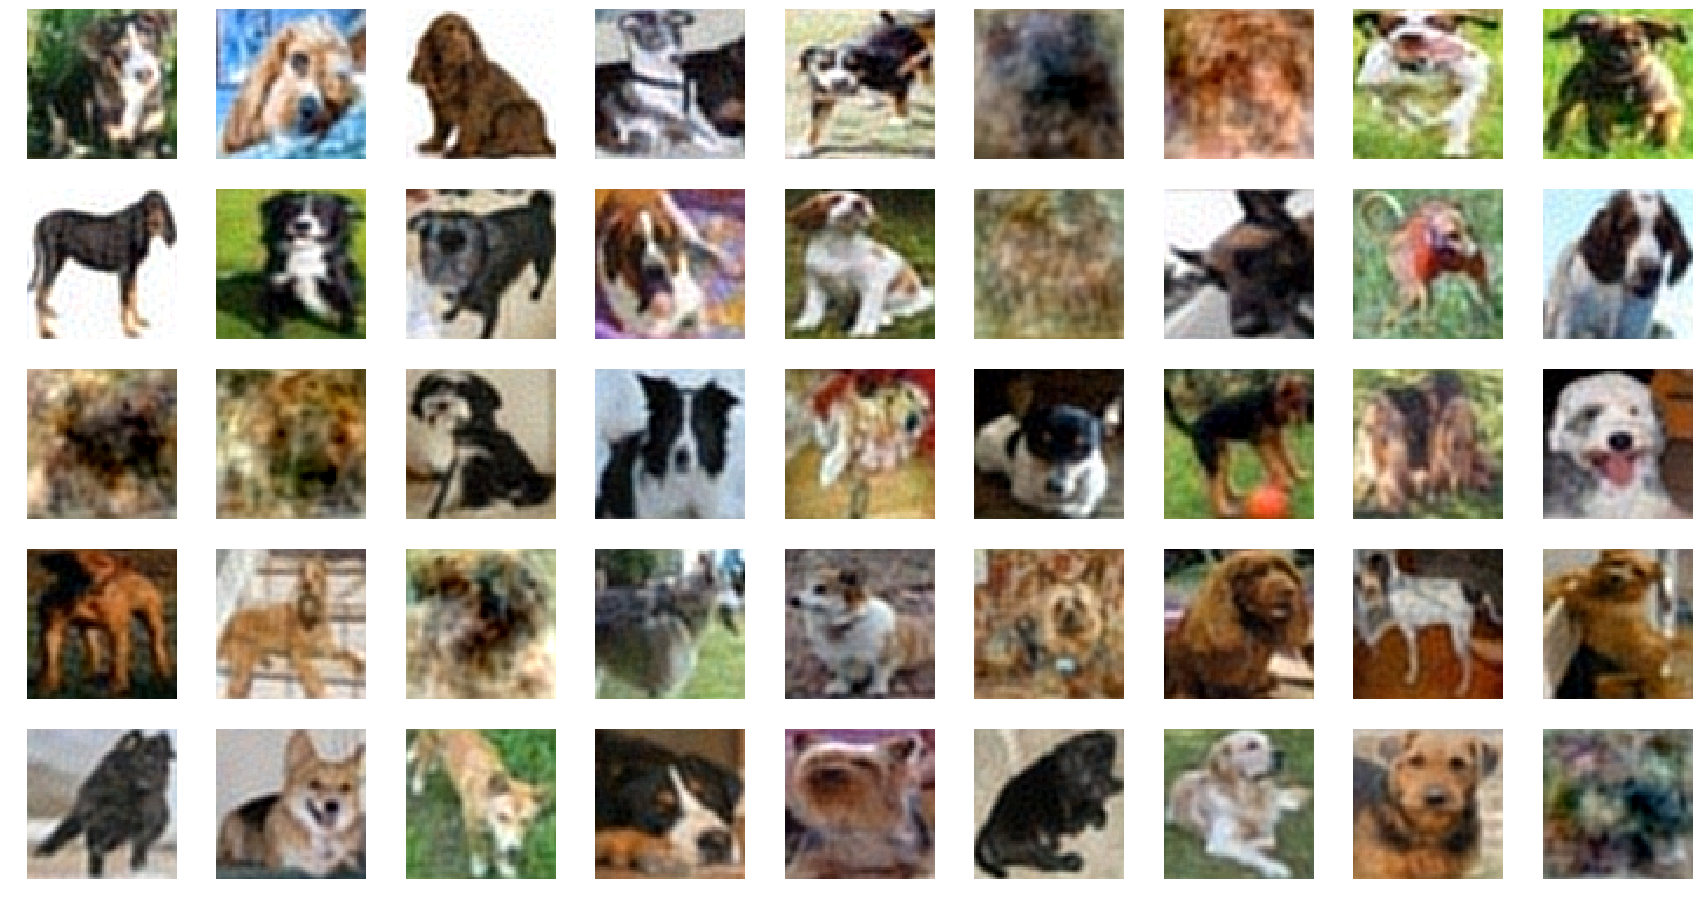

In [13]:
# generate several random samples from the gaussian mixture model and present them
num_rows = 5
num_cols = 9
num_images_to_show = num_rows*num_cols

sampled_latents = dog_gaussian_mixture_model.sample(num_images_to_show)[0]
print(sampled_latents.shape, sampled_latents.mean(), sampled_latents.std())

random_doglike_vectors = dog_PCA.inverse_transform(sampled_latents)
print(random_doglike_vectors.shape, random_doglike_vectors.mean(), random_doglike_vectors.std())

plt.figure(figsize=(30,16))
for k in range(num_images_to_show):
    doglike_image = np.reshape(random_doglike_vectors[k,:],(image_dimention,image_dimention,3))
    doglike_image[doglike_image > 255] = 255
    doglike_image[doglike_image <   0] =   0

    plt.subplot(num_rows,num_cols,k+1); plt.imshow(doglike_image.astype(np.uint8)); plt.axis("off")

# Compare marginal distributions as validation
compare the scatter plots of pairwise distributions in the PCA space of real images, single gaussian, mixture of gaussians

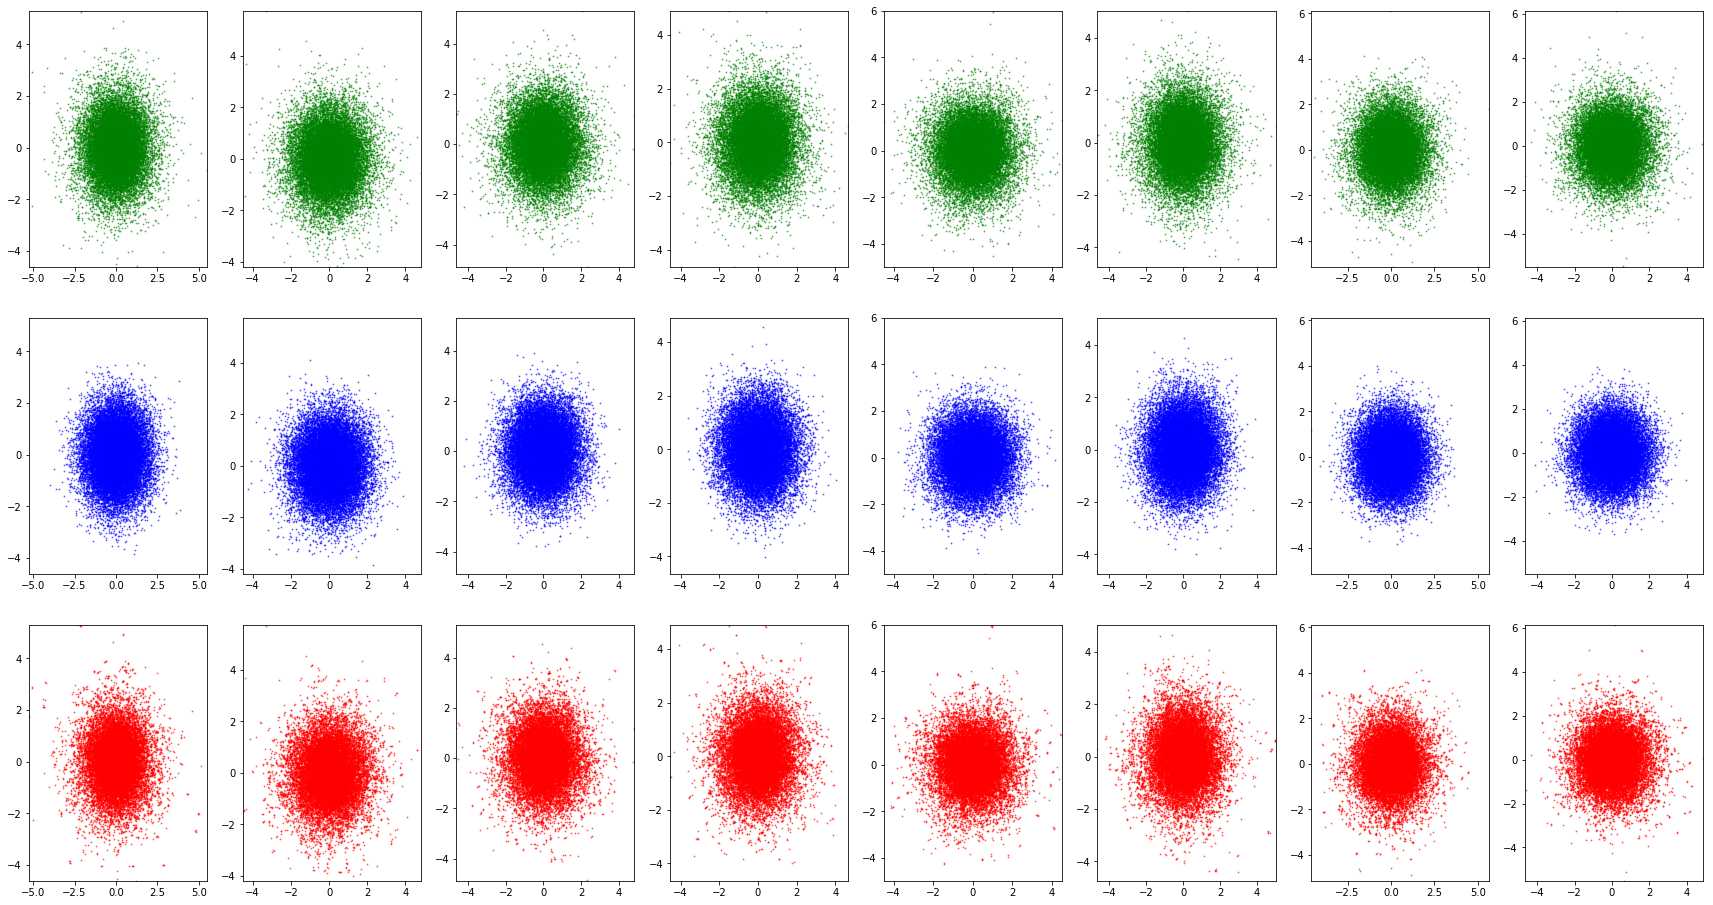

In [14]:
# show some 2D histograms of feature pairs of: original distribution, single gaussian distribution, GMM distribution
X_single_gaussian    = dog_single_gaussian_model.sample(X_pca.shape[0])[0]
X_multiple_gaussians = dog_gaussian_mixture_model.sample(X_pca.shape[0])[0]

num_cols = 8

plt.figure(figsize=(30,16))
for k in range(num_cols):
    feature_pair = np.random.choice(num_components, size=2, replace=False)
    
    original_data          = X_pca[:,feature_pair]
    single_gaussian_data   = X_single_gaussian[:,feature_pair]
    multiple_gaussian_data = X_multiple_gaussians[:,feature_pair]
    
    all_xs = np.concatenate((original_data[:,0],single_gaussian_data[:,0],multiple_gaussian_data[:,0]))
    all_ys = np.concatenate((original_data[:,1],single_gaussian_data[:,1],multiple_gaussian_data[:,1]))
    xlimits = [min(all_xs),max(all_xs)]
    ylimits = [min(all_ys),max(all_ys)]
    plt.subplot(3,num_cols,k+1+0*num_cols); plt.scatter(original_data[:,0],original_data[:,1],c='g',s=0.8, alpha=0.5); plt.xlim(xlimits); plt.ylim(ylimits);
    plt.subplot(3,num_cols,k+1+1*num_cols); plt.scatter(single_gaussian_data[:,0],single_gaussian_data[:,1],c='b',s=0.8, alpha=0.5); plt.xlim(xlimits); plt.ylim(ylimits);
    plt.subplot(3,num_cols,k+1+2*num_cols); plt.scatter(multiple_gaussian_data[:,0],multiple_gaussian_data[:,1],c='r',s=0.8, alpha=0.5); plt.xlim(xlimits); plt.ylim(ylimits);

# Create a submission

In [15]:
num_images_to_submit = 10000

sampled_latents = dog_gaussian_mixture_model.sample(num_images_to_submit)[0]
random_doglike_vectors = dog_PCA.inverse_transform(sampled_latents)

z = zipfile.PyZipFile('images.zip', mode='w')
for k in range(num_images_to_submit):
    doglike_image = np.reshape(random_doglike_vectors[k,:],(image_dimention,image_dimention,3))
    doglike_image[doglike_image > 255] = 255
    doglike_image[doglike_image <   0] =   0
    image_to_save = Image.fromarray(doglike_image.astype(np.uint8))

    image_filename = '%d.png' %(k)
    image_to_save.save(image_filename,'PNG'); z.write(image_filename); os.remove(image_filename)
print('finished writing "image.zip"')

finished writing "image.zip"


# Calculate MiFID 
(from kaggle)

In [16]:
from __future__ import absolute_import, division, print_function
import gzip, pickle
import tensorflow as tf
from scipy import linalg
import pathlib
import urllib
import warnings
from tqdm import tqdm

class KernelEvalException(Exception):
    pass

model_params = {
    'Inception': {
        'name': 'Inception', 
        'imsize': 64,
        'output_layer': 'Pretrained_Net/pool_3:0', 
        'input_layer': 'Pretrained_Net/ExpandDims:0',
        'output_shape': 2048,
        'cosine_distance_eps': 0.1
        }
}

def create_model_graph(pth):
    """Creates a graph from saved GraphDef file."""
    # Creates graph from saved graph_def.pb.
    with tf.gfile.FastGFile( pth, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString( f.read())
        _ = tf.import_graph_def( graph_def, name='Pretrained_Net')

def _get_model_layer(sess, model_name):
    # layername = 'Pretrained_Net/final_layer/Mean:0'
    layername = model_params[model_name]['output_layer']
    layer = sess.graph.get_tensor_by_name(layername)
    ops = layer.graph.get_operations()
    for op_idx, op in enumerate(ops):
        for o in op.outputs:
            shape = o.get_shape()
            if shape._dims != []:
              shape = [s.value for s in shape]
              new_shape = []
              for j, s in enumerate(shape):
                if s == 1 and j == 0:
                  new_shape.append(None)
                else:
                  new_shape.append(s)
              o.__dict__['_shape_val'] = tf.TensorShape(new_shape)
    return layer

def get_activations(images, sess, model_name, batch_size=50, verbose=False):
    """Calculates the activations of the pool_3 layer for all images.

    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 256.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the disposable hardware.
    -- verbose    : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- A numpy array of dimension (num images, 2048) that contains the
       activations of the given tensor when feeding inception with the query tensor.
    """
    inception_layer = _get_model_layer(sess, model_name)
    n_images = images.shape[0]
    if batch_size > n_images:
        print("warning: batch size is bigger than the data size. setting batch size to data size")
        batch_size = n_images
    n_batches = n_images//batch_size + 1
    pred_arr = np.empty((n_images,model_params[model_name]['output_shape']))
    for i in tqdm(range(n_batches)):
        if verbose:
            print("\rPropagating batch %d/%d" % (i+1, n_batches), end="", flush=True)
        start = i*batch_size
        if start+batch_size < n_images:
            end = start+batch_size
        else:
            end = n_images
                    
        batch = images[start:end]
        pred = sess.run(inception_layer, {model_params[model_name]['input_layer']: batch})
        pred_arr[start:end] = pred.reshape(-1,model_params[model_name]['output_shape'])
    if verbose:
        print(" done")
    return pred_arr


# def calculate_memorization_distance(features1, features2):
#     neigh = NearestNeighbors(n_neighbors=1, algorithm='kd_tree', metric='euclidean')
#     neigh.fit(features2) 
#     d, _ = neigh.kneighbors(features1, return_distance=True)
#     print('d.shape=',d.shape)
#     return np.mean(d)

def normalize_rows(x: np.ndarray):
    """
    function that normalizes each row of the matrix x to have unit length.

    Args:
     ``x``: A numpy matrix of shape (n, m)

    Returns:
     ``x``: The normalized (by row) numpy matrix.
    """
    return np.nan_to_num(x/np.linalg.norm(x, ord=2, axis=1, keepdims=True))


def cosine_distance(features1, features2):
    # print('rows of zeros in features1 = ',sum(np.sum(features1, axis=1) == 0))
    # print('rows of zeros in features2 = ',sum(np.sum(features2, axis=1) == 0))
    features1_nozero = features1[np.sum(features1, axis=1) != 0]
    features2_nozero = features2[np.sum(features2, axis=1) != 0]
    norm_f1 = normalize_rows(features1_nozero)
    norm_f2 = normalize_rows(features2_nozero)

    d = 1.0-np.abs(np.matmul(norm_f1, norm_f2.T))
    print('d.shape=',d.shape)
    print('np.min(d, axis=1).shape=',np.min(d, axis=1).shape)
    mean_min_d = np.mean(np.min(d, axis=1))
    print('distance=',mean_min_d)
    return mean_min_d


def distance_thresholding(d, eps):
    if d < eps:
        return d
    else:
        return 1

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
            
    Stable version by Dougal J. Sutherland.

    Params:
    -- mu1 : Numpy array containing the activations of the pool_3 layer of the
             inception net ( like returned by the function 'get_predictions')
             for generated samples.
    -- mu2   : The sample mean over activations of the pool_3 layer, precalcualted
               on an representive data set.
    -- sigma1: The covariance matrix over activations of the pool_3 layer for
               generated samples.
    -- sigma2: The covariance matrix over activations of the pool_3 layer,
               precalcualted on an representive data set.

    Returns:
    --   : The Frechet Distance.
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, "Training and test mean vectors have different lengths"
    assert sigma1.shape == sigma2.shape, "Training and test covariances have different dimensions"

    diff = mu1 - mu2

    # product might be almost singular
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = "fid calculation produces singular product; adding %s to diagonal of cov estimates" % eps
        warnings.warn(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        # covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))
    
    # numerical error might give slight imaginary component
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
            raise ValueError("Imaginary component {}".format(m))
        covmean = covmean.real

    # covmean = tf.linalg.sqrtm(tf.linalg.matmul(sigma1,sigma2))

    print('covmean.shape=',covmean.shape)
    # tr_covmean = tf.linalg.trace(covmean)

    tr_covmean = np.trace(covmean)
    return diff.dot(diff) + np.trace(sigma1) + np.trace(sigma2) - 2 * tr_covmean
    # return diff.dot(diff) + tf.linalg.trace(sigma1) + tf.linalg.trace(sigma2) - 2 * tr_covmean
#-------------------------------------------------------------------------------


def calculate_activation_statistics(images, sess, model_name, batch_size=50, verbose=False):
    """Calculation of the statistics used by the FID.
    Params:
    -- images      : Numpy array of dimension (n_images, hi, wi, 3). The values
                     must lie between 0 and 255.
    -- sess        : current session
    -- batch_size  : the images numpy array is split into batches with batch size
                     batch_size. A reasonable batch size depends on the available hardware.
    -- verbose     : If set to True and parameter out_step is given, the number of calculated
                     batches is reported.
    Returns:
    -- mu    : The mean over samples of the activations of the pool_3 layer of
               the incption model.
    -- sigma : The covariance matrix of the activations of the pool_3 layer of
               the incption model.
    """
    act = get_activations(images, sess, model_name, batch_size, verbose)
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma, act
    
def _handle_path_memorization(path, sess, model_name, is_checksize, is_check_png):
    path = pathlib.Path(path)
    files = list(path.glob('*.jpg')) + list(path.glob('*.png'))
    imsize = model_params[model_name]['imsize']

    # In production we don't resize input images. This is just for demo purpose. 
    x = np.array([np.array(img_read_checks(fn, imsize, is_checksize, imsize, is_check_png)) for fn in files])
    m, s, features = calculate_activation_statistics(x, sess, model_name)
    del x #clean up memory
    return m, s, features

# check for image size
def img_read_checks(filename, resize_to, is_checksize=False, check_imsize = 64, is_check_png = False):
    im = Image.open(str(filename))
    if is_checksize and im.size != (check_imsize,check_imsize):
        raise KernelEvalException('The images are not of size '+str(check_imsize))
    
    if is_check_png and im.format != 'PNG':
        raise KernelEvalException('Only PNG images should be submitted.')

    if resize_to is None:
        return im
    else:
        return im.resize((resize_to,resize_to),Image.ANTIALIAS)

def calculate_kid_given_paths(paths, model_name, model_path, feature_path=None, mm=[], ss=[], ff=[]):
    ''' Calculates the KID of two paths. '''
    tf.reset_default_graph()
    create_model_graph(str(model_path))
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        m1, s1, features1 = _handle_path_memorization(paths[0], sess, model_name, is_checksize = True, is_check_png = True)
        if len(mm) != 0:
            m2 = mm
            s2 = ss
            features2 = ff
        elif feature_path is None:
            m2, s2, features2 = _handle_path_memorization(paths[1], sess, model_name, is_checksize = False, is_check_png = False)
        else:
            with np.load(feature_path) as f:
                m2, s2, features2 = f['m'], f['s'], f['features']

        print('m1,m2 shape=',(m1.shape,m2.shape),'s1,s2=',(s1.shape,s2.shape))
        print('starting calculating FID')
        fid_value = calculate_frechet_distance(m1, s1, m2, s2)
        print('done with FID, starting distance calculation')
        distance = cosine_distance(features1, features2)        
        return fid_value, distance, m2, s2, features2


In [17]:
calculate_MiFID_score = False

if calculate_MiFID_score:
    # UNCOMPRESS OUR IMGAES
    with zipfile.ZipFile("../working/images.zip","r") as z:
        z.extractall("../tmp/images2/")

    # COMPUTE LB SCORE
    m2 = []; s2 =[]; f2 = []
    user_images_unzipped_path = '../tmp/images2/'
    images_path = [user_images_unzipped_path,'../input/generative-dog-images/all-dogs/all-dogs/']
    public_path = '../input/dog-face-generation-competition-kid-metric-input/classify_image_graph_def.pb'

    fid_epsilon = 10e-15

    fid_value_public, distance_public, m2, s2, f2 = calculate_kid_given_paths(images_path, 'Inception', public_path, mm=m2, ss=s2, ff=f2)
    distance_public = distance_thresholding(distance_public, model_params['Inception']['cosine_distance_eps'])
    print("FID_public: ", fid_value_public, "distance_public: ", distance_public, "multiplied_public: ",
            fid_value_public /(distance_public + fid_epsilon))

    # REMOVE FILES TO PREVENT KERNEL ERROR OF TOO MANY FILES
    ! rm -r ../tmp